### Cleaning and Split Dataset

In [28]:
import os
import time
import copy
from tqdm import tqdm
from PIL import Image
import torch
import random
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt

# =========================
# CONFIGURASI DATASET
# =========================

# Path dataset di Kaggle (sesuaikan kalau berbeda)
SOURCE_DIR = "/kaggle/input/waste-classification"
OUTPUT_DIR = "waste_clean_dataset"

TRAIN_SPLIT = 0.70
VAL_SPLIT   = 0.15
TEST_SPLIT  = 0.15

IMG_SIZE = (224, 224)

# Deteksi semua kelas dari folder sumber
class_names = sorted([
    d for d in os.listdir(SOURCE_DIR)
    if os.path.isdir(os.path.join(SOURCE_DIR, d))
])
print("Detected classes:", class_names)

# Buat struktur folder clean_dataset: train/val/test per kelas
for folder in ["train", "val", "test"]:
    for cls in class_names:
        os.makedirs(os.path.join(OUTPUT_DIR, folder, cls), exist_ok=True)

# =========================
# FUNGSI CLEANING IMAGE
# =========================

def clean_and_save(src_path, dst_path):
    try:
        # file terlalu kecil (potensi corrupt) → skip
        if os.path.getsize(src_path) < 10 * 1024:  # 10 KB
            return False

        img = Image.open(src_path)
        img = img.convert("RGB")
        img = img.resize(IMG_SIZE)
        img.save(dst_path, "JPEG")
        return True

    except Exception:
        return False

# =========================
# FUNGSI PROSES PER KELAS
# =========================

def process_class(class_name):
    src_class = os.path.join(SOURCE_DIR, class_name)
    files = os.listdir(src_class)

    # hanya file gambar
    files = [f for f in files if f.lower().endswith((".jpg",".jpeg",".png",".bmp",".gif"))]
    random.shuffle(files)

    total = len(files)
    train_end = int(TRAIN_SPLIT * total)
    val_end   = train_end + int(VAL_SPLIT * total)

    train_files = files[:train_end]
    val_files   = files[train_end:val_end]
    test_files  = files[val_end:]

    counters = {"train": 0, "val": 0, "test": 0}
    deleted = 0

    for file_list, folder in [
        (train_files, "train"),
        (val_files, "val"),
        (test_files, "test")
    ]:
        for f in tqdm(file_list, desc=f"{class_name} → {folder}"):
            src_path = os.path.join(src_class, f)
            dst_path = os.path.join(OUTPUT_DIR, folder, class_name, f)

            ok = clean_and_save(src_path, dst_path)
            if ok:
                counters[folder] += 1
            else:
                deleted += 1

    print("\nClass:", class_name)
    print("Train :", counters["train"])
    print("Val   :", counters["val"])
    print("Test  :", counters["test"])
    print("Deleted (corrupt):", deleted)

# =========================
# JALANKAN CLEANING + SPLIT
# =========================

for cls in class_names:
    process_class(cls)

print("CLEANING + SPLITTING SELESAI!")
print("Dataset akhir di:", OUTPUT_DIR)


Detected classes: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']


1-Cardboard → test: 100%|██████████| 70/70 [00:00<00:00, 114.36it/s]



Class: 1-Cardboard
Train : 322
Val   : 69
Test  : 70
Deleted (corrupt): 0


2-Food Organics → test: 100%|██████████| 63/63 [00:00<00:00, 107.52it/s]



Class: 2-Food Organics
Train : 287
Val   : 61
Test  : 63
Deleted (corrupt): 0


3-Glass → test: 100%|██████████| 63/63 [00:00<00:00, 117.57it/s]



Class: 3-Glass
Train : 294
Val   : 63
Test  : 63
Deleted (corrupt): 0


4-Metal → test: 100%|██████████| 119/119 [00:01<00:00, 116.70it/s]



Class: 4-Metal
Train : 553
Val   : 118
Test  : 119
Deleted (corrupt): 0


5-Miscellaneous Trash → test: 100%|██████████| 75/75 [00:00<00:00, 119.43it/s]



Class: 5-Miscellaneous Trash
Train : 346
Val   : 74
Test  : 75
Deleted (corrupt): 0


6-Paper → test: 100%|██████████| 75/75 [00:00<00:00, 120.16it/s]



Class: 6-Paper
Train : 350
Val   : 75
Test  : 75
Deleted (corrupt): 0


7-Plastic → test: 100%|██████████| 139/139 [00:01<00:00, 121.80it/s]



Class: 7-Plastic
Train : 644
Val   : 138
Test  : 139
Deleted (corrupt): 0


8-Textile Trash → test: 100%|██████████| 49/49 [00:00<00:00, 121.53it/s]



Class: 8-Textile Trash
Train : 222
Val   : 47
Test  : 49
Deleted (corrupt): 0


9-Vegetation → test: 100%|██████████| 66/66 [00:00<00:00, 112.21it/s]


Class: 9-Vegetation
Train : 305
Val   : 65
Test  : 66
Deleted (corrupt): 0
CLEANING + SPLITTING SELESAI!
Dataset akhir di: waste_clean_dataset


### ARGUMENT, DEVICE, TRANSFORMS, DATALOADER

In [29]:
import argparse

# =========================
# PARAMETER TRAINING
# =========================

def get_args():
    parser = argparse.ArgumentParser(description="Train EfficientNetB0 on Waste Classification")
    parser.add_argument("--data_dir", type=str, default=OUTPUT_DIR,
                        help="Root folder with train/val/test subfolders")
    parser.add_argument("--output_dir", type=str, default="effnet_waste_output",
                        help="Where to save checkpoints and logs")
    parser.add_argument("--epochs", type=int, default=15)
    parser.add_argument("--batch_size", type=int, default=32)
    parser.add_argument("--img_size", type=int, default=224)
    parser.add_argument("--workers", type=int, default=4)
    parser.add_argument("--lr", type=float, default=0.001)   # EffNet biasanya enak di lr kecil + Adam
    parser.add_argument("--weight_decay", type=float, default=1e-4)
    parser.add_argument("--seed", type=int, default=42)
    parser.add_argument("--resume", type=str, default="", help="Path to checkpoint to resume (optional)")
    parser.add_argument("--num_classes", type=int, default=len(class_names))
    args = parser.parse_args([])
    return args

args = get_args()

torch.manual_seed(args.seed)
np.random.seed(args.seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

os.makedirs(args.output_dir, exist_ok=True)

# =========================
# AUGMENTASI & NORMALISASI
# =========================

train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(args.img_size, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.1),          # <-- baru
    transforms.RandomRotation(10),                 # <-- baru
    transforms.ColorJitter(brightness=0.2, contrast=0.2,
                           saturation=0.1, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(int(args.img_size * 1.14)),
    transforms.CenterCrop(args.img_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# =========================
# DATASET & DATALOADER
# =========================

train_dir = os.path.join(args.data_dir, "train")
val_dir   = os.path.join(args.data_dir, "val")
test_dir  = os.path.join(args.data_dir, "test")

train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset   = datasets.ImageFolder(val_dir, transform=val_test_transforms)
test_dataset  = datasets.ImageFolder(test_dir, transform=val_test_transforms)

class_names = train_dataset.classes
print("Classes:", class_names)
print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))
print("Test samples:", len(test_dataset))

train_loader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True,
                          num_workers=args.workers, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False,
                          num_workers=args.workers, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=False,
                          num_workers=args.workers, pin_memory=True)


Device: cuda
Classes: ['1-Cardboard', '2-Food Organics', '3-Glass', '4-Metal', '5-Miscellaneous Trash', '6-Paper', '7-Plastic', '8-Textile Trash', '9-Vegetation']
Train samples: 4698
Val samples: 2247
Test samples: 2265


### Build Model EfficientNetB0 + LOSS & OPTIMIZER

In [30]:
# =========================
# BANGUN MODEL EFFICIENTNETB0
# =========================

def build_model(num_classes):
    # Load EfficientNetB0 pretrained ImageNet
    try:
        weights = models.EfficientNet_B0_Weights.IMAGENET1K_V1
        model = models.efficientnet_b0(weights=weights)
    except AttributeError:
        model = models.efficientnet_b0(pretrained=True)

    # Bangun ulang classifier: Dropout + Linear(num_classes)
    if isinstance(model.classifier, nn.Sequential):
        in_features = model.classifier[-1].in_features
    else:
        in_features = model.classifier.in_features

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.4),            # <-- regularisasi tambahan
        nn.Linear(in_features, num_classes)
    )

    return model


model = build_model(len(class_names))
model = model.to(device)

# =========================
# LOSS, OPTIMIZER, SCHEDULER
# =========================

criterion = nn.CrossEntropyLoss()

# Adam biasanya cocok untuk fine-tuning EfficientNet
optimizer = torch.optim.AdamW(model.parameters(), lr=args.lr,
                              weight_decay=args.weight_decay)

# Cosine Annealing boleh tetap dipakai
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)

scaler = GradScaler()

start_epoch = 0
best_val_acc = 0.0

# =========================
# OPSIONAL: RESUME CHECKPOINT
# =========================

if args.resume:
    print("=> Loading checkpoint", args.resume)
    ckpt = torch.load(args.resume, map_location=device)
    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scheduler.load_state_dict(ckpt.get("scheduler_state", scheduler.state_dict()))
    start_epoch = ckpt.get("epoch", 0) + 1
    best_val_acc = ckpt.get("best_val_acc", 0.0)
    print(f"=> Resumed from epoch {start_epoch}, best_val_acc={best_val_acc:.4f}")


/tmp/ipykernel_47/2043956600.py:43: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


### TRAINING & VALIDATION LOOP

In [31]:
# =========================
# TRAINING & VALIDATION LOOP
# =========================

def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [Train]")
    for inputs, labels in pbar:
        inputs = inputs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).item()
        total += inputs.size(0)

        pbar.set_postfix(loss=running_loss/total, acc=running_corrects/total)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def validate(epoch):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():
        pbar = tqdm(val_loader, desc=f"Epoch {epoch} [Val]")
        for inputs, labels in pbar:
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data).item()
            total += inputs.size(0)

            pbar.set_postfix(loss=running_loss/total, acc=running_corrects/total)

    epoch_loss = running_loss / total
    epoch_acc = running_corrects / total
    return epoch_loss, epoch_acc

def save_checkpoint(state, filename):
    torch.save(state, filename)

# =========================
# MAIN TRAINING LOOP
# =========================

since = time.time()
history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(start_epoch, args.epochs):
    train_loss, train_acc = train_one_epoch(epoch+1)
    val_loss, val_acc = validate(epoch+1)

    scheduler.step()

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch+1}/{args.epochs}  "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}  |  "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")

    # simpan best
    is_best = val_acc > best_val_acc
    if is_best:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    ckpt_path = os.path.join(args.output_dir, f"ckpt_epoch_{epoch+1}.pth")
    save_checkpoint({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "best_val_acc": best_val_acc,
    }, ckpt_path)

best_path = os.path.join(args.output_dir, "effnetb0_best.pth")
if 'best_model_wts' in locals():
    torch.save(best_model_wts, best_path)
    print("Best model saved to:", best_path)
else:
    torch.save(model.state_dict(), best_path)
    print("Model (last epoch) saved to:", best_path)

time_elapsed = time.time() - since
print(f"Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s. "
      f"Best val acc: {best_val_acc:.4f}")


Epoch 1 [Train]:   0%|          | 0/147 [00:00<?, ?it/s]/tmp/ipykernel_47/3867343108.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]:   0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_47/3867343108.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 [Val]: 100%|██████████| 71/71 [00:03<00:00, 21.11it/s, acc=0.841, loss=0.456]


Epoch 1/15  Train Loss: 0.9551 Acc: 0.6752  |  Val Loss: 0.4563 Acc: 0.8411


Epoch 2 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.36it/s, acc=0.891, loss=0.313]


Epoch 2/15  Train Loss: 0.5493 Acc: 0.8103  |  Val Loss: 0.3133 Acc: 0.8914


Epoch 3 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.10it/s, acc=0.927, loss=0.244]


Epoch 3/15  Train Loss: 0.4209 Acc: 0.8519  |  Val Loss: 0.2436 Acc: 0.9266


Epoch 4 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.29it/s, acc=0.941, loss=0.168] 


Epoch 4/15  Train Loss: 0.3617 Acc: 0.8702  |  Val Loss: 0.1684 Acc: 0.9408


Epoch 5 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.42it/s, acc=0.945, loss=0.168] 


Epoch 5/15  Train Loss: 0.2759 Acc: 0.9036  |  Val Loss: 0.1683 Acc: 0.9453


Epoch 6 [Val]: 100%|██████████| 71/71 [00:03<00:00, 21.91it/s, acc=0.976, loss=0.0852]


Epoch 6/15  Train Loss: 0.2186 Acc: 0.9238  |  Val Loss: 0.0852 Acc: 0.9755


Epoch 7 [Val]: 100%|██████████| 71/71 [00:03<00:00, 21.86it/s, acc=0.988, loss=0.0403]


Epoch 7/15  Train Loss: 0.1537 Acc: 0.9459  |  Val Loss: 0.0403 Acc: 0.9884


Epoch 8 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.07it/s, acc=0.994, loss=0.0239]


Epoch 8/15  Train Loss: 0.1142 Acc: 0.9610  |  Val Loss: 0.0239 Acc: 0.9938


Epoch 9 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.06it/s, acc=0.992, loss=0.0274]


Epoch 9/15  Train Loss: 0.0955 Acc: 0.9700  |  Val Loss: 0.0274 Acc: 0.9924


Epoch 10 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.01it/s, acc=0.996, loss=0.0119] 


Epoch 10/15  Train Loss: 0.0645 Acc: 0.9796  |  Val Loss: 0.0119 Acc: 0.9964


Epoch 11 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.31it/s, acc=0.999, loss=0.00487]


Epoch 11/15  Train Loss: 0.0475 Acc: 0.9857  |  Val Loss: 0.0049 Acc: 0.9987


Epoch 12 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.05it/s, acc=0.998, loss=0.00582]


Epoch 12/15  Train Loss: 0.0296 Acc: 0.9913  |  Val Loss: 0.0058 Acc: 0.9982


Epoch 13 [Val]: 100%|██████████| 71/71 [00:03<00:00, 21.83it/s, acc=0.998, loss=0.00541]


Epoch 13/15  Train Loss: 0.0271 Acc: 0.9917  |  Val Loss: 0.0054 Acc: 0.9982


Epoch 14 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.03it/s, acc=0.999, loss=0.00391]


Epoch 14/15  Train Loss: 0.0272 Acc: 0.9911  |  Val Loss: 0.0039 Acc: 0.9987


Epoch 15 [Val]: 100%|██████████| 71/71 [00:03<00:00, 22.31it/s, acc=0.999, loss=0.00374]


Epoch 15/15  Train Loss: 0.0210 Acc: 0.9938  |  Val Loss: 0.0037 Acc: 0.9987
Best model saved to: effnet_waste_output/effnetb0_best.pth
Training complete in 5m 24s. Best val acc: 0.9987


### EVALUASI PADA TEST SET + VISUALISASI

Test:   0%|          | 0/71 [00:00<?, ?it/s]/tmp/ipykernel_47/3542191231.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Test: 100%|██████████| 71/71 [00:03<00:00, 21.63it/s]


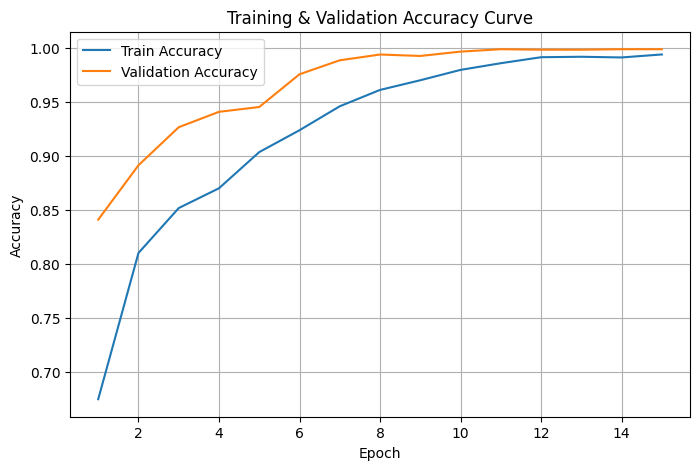

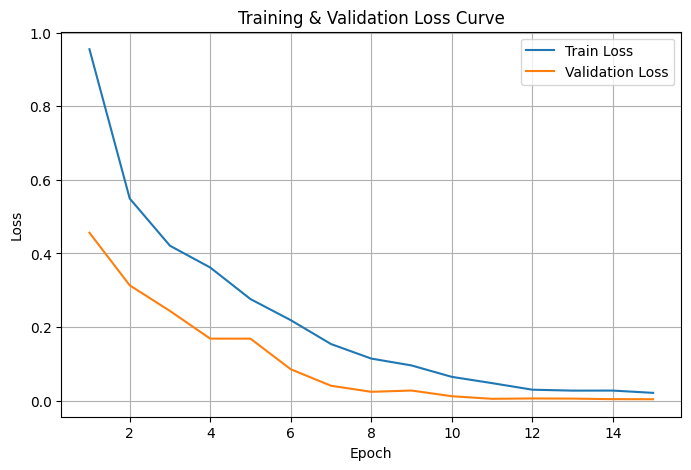

Test Accuracy: 0.9991
Classification Report:
                       precision    recall  f1-score   support

          1-Cardboard       1.00      1.00      1.00       221
      2-Food Organics       1.00      1.00      1.00       198
              3-Glass       1.00      1.00      1.00       202
              4-Metal       0.99      1.00      1.00       366
5-Miscellaneous Trash       1.00      1.00      1.00       246
              6-Paper       1.00      1.00      1.00       236
            7-Plastic       1.00      1.00      1.00       436
      8-Textile Trash       1.00      1.00      1.00       156
         9-Vegetation       1.00      1.00      1.00       204

             accuracy                           1.00      2265
            macro avg       1.00      1.00      1.00      2265
         weighted avg       1.00      1.00      1.00      2265



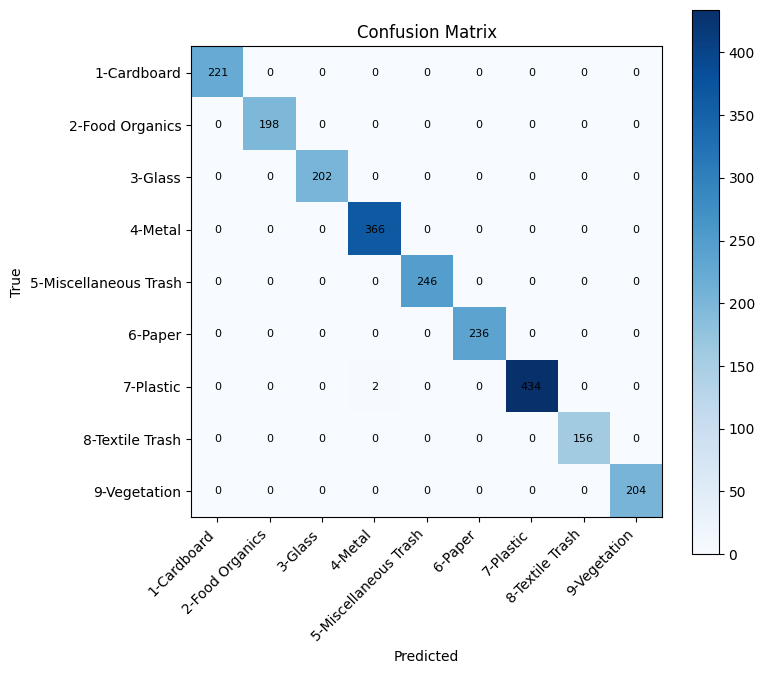

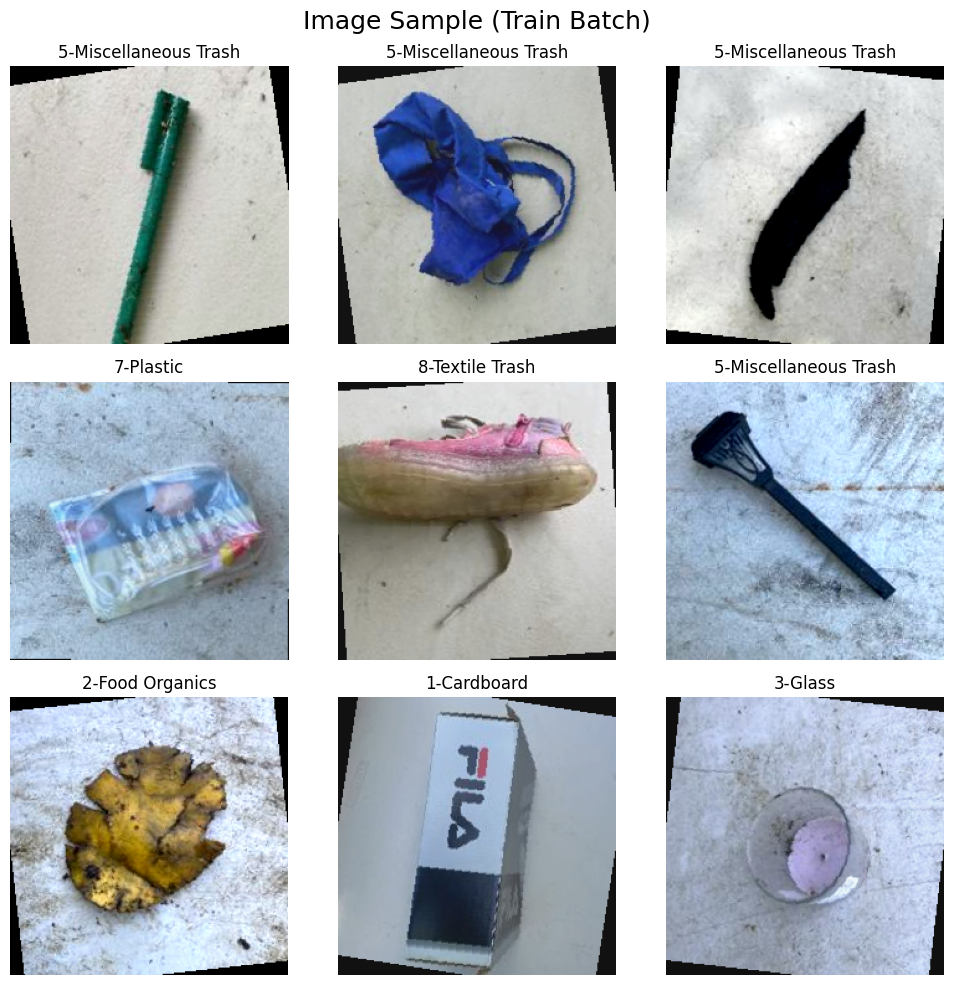

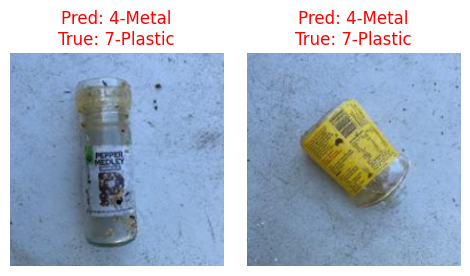

In [32]:
# =========================
# EVALUASI DI TEST SET
# =========================

model.load_state_dict(torch.load(best_path, map_location=device))
model = model.to(device)
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    pbar = tqdm(test_loader, desc="Test")
    for inputs, labels in pbar:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with autocast():
            outputs = model(inputs)

        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# =========================
# PLOT ACCURACY & LOSS
# =========================

def plot_accuracy(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, val_acc, label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history["train_acc"], history["val_acc"])
plot_loss(history["train_loss"], history["val_loss"])

# =========================
# CONFUSION MATRIX + REPORT
# =========================

print("Test Accuracy: {:.4f}".format(accuracy_score(all_labels, all_preds)))
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,7))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.colorbar()

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black", fontsize=8)

plt.xticks(np.arange(len(class_names)), class_names, rotation=45, ha="right")
plt.yticks(np.arange(len(class_names)), class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

# =========================
# VISUALISASI SAMPEL TRAIN
# =========================

images, labels_batch = next(iter(train_loader))

plt.figure(figsize=(10,10))
plt.suptitle('Image Sample (Train Batch)', fontsize=18)

for i in range(min(9, len(images))):
    img = images[i].permute(1, 2, 0).cpu().numpy()
    img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    img = np.clip(img, 0, 1)

    plt.subplot(3, 3, i+1)
    plt.imshow(img)
    plt.title(class_names[labels_batch[i]])
    plt.axis('off')

plt.tight_layout()
plt.show()

# =========================
# TAMPILKAN MISCLASSIFIED
# =========================

def show_misclassified(dataset, preds, labels, class_names, n=10):
    errors = [i for i in range(len(labels)) if preds[i] != labels[i]]

    if len(errors) == 0:
        print("Tidak ada gambar yang salah prediksi!")
        return

    idxs = errors[:n]

    plt.figure(figsize=(12, 12))
    for i, idx in enumerate(idxs):
        img, label = dataset[idx]
        pred = preds[idx]

        img = img.permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)

        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"Pred: {class_names[pred]}\nTrue: {class_names[label]}",
                  color="red")

    plt.tight_layout()
    plt.show()

show_misclassified(test_dataset, all_preds, all_labels, class_names, n=10)
